In [2]:
! pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [3]:

import os 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import product
from tqdm import tqdm


# ======================================================================
# PARÂMETROS GLOBAIS DO MODELO
# ======================================================================

In [4]:




R_1 = 1            # Raio característico do nível 1
O_1 = 1            # Frequência angular base
x_1 = np.array([0, 0])  # Centro inicial (nível 1)

# Fator de escala entre frequências dos níveis
lamb = 2**(2/3)


# ======================================================================
# INTEGRADOR NUMÉRICO: RUNGE-KUTTA DE 4ª ORDEM (RK4)
# ======================================================================

In [5]:


def solve_RK4(func, r0, t0, dt, t_max):
    """
    Resolve o sistema dr/dt = func(t, r) usando RK4.

    Parâmetros:
    - func : função do campo vetorial
    - r0   : condição inicial (array)
    - t0   : tempo inicial
    - dt   : passo de tempo
    - t_max: tempo final
    """
    Nt = int((t_max - t0)/dt) + 1
    r = np.zeros((Nt, *r0.shape))
    t = np.zeros(Nt)

    r[0] = r0
    t[0] = t0

    for i in range(Nt - 1):
        ti = t[i]
        ri = r[i]

        k1 = func(ti, ri)
        k2 = func(ti + dt/2, ri + dt/2*k1)
        k3 = func(ti + dt/2, ri + dt/2*k2)
        k4 = func(ti + dt,   ri + dt*k3)

        r[i+1] = ri + dt/6*(k1 + 2*k2 + 2*k3 + k4)
        t[i+1] = ti + dt

    return t, r

# ======================================================================
# ESTRUTURA HIERÁRQUICA DOS NÍVEIS
# ======================================================================

In [6]:


def indices_nivel(n):
    """
    Gera os índices que identificam cada centro no nível n.
    O número de centros cresce como 4^(n-1).
    """
    if n == 1:
        return [[]]
    return list(product(range(4), repeat=n-1))


def R(n):
    """ Raio característico do nível n """
    return R_1 * 2**(1 - n)


def Omega(n):
    """ Frequência angular do nível n """
    return O_1 * lamb**(n - 1)


def T(n):
    """ Período associado ao nível n """
    return 2 * np.pi / Omega(n)


# ======================================================================
# GEOMETRIA DOS CENTROS
# ======================================================================

def phi(n, index):
    """
    Fase angular associada ao último índice da hierarquia.
    """
    return np.pi * (1/4 + (index[-1] - 1) / 2)


def x_centros(n, index, t):
    """
    Calcula recursivamente a posição do centro associado
    a um índice hierárquico no nível n.
    """
    if n == 1:
        return x_1

    if len(index) != n - 1:
        raise ValueError("Erro de tamanho de array")

    # Deslocamento circular do centro atual
    diff = R(n) * np.sqrt(2) * np.array([
        np.cos(Omega(n) * t + phi(n, index)),
        np.sin(Omega(n) * t + phi(n, index))
    ])

    # Soma com o centro do nível anterior
    return diff + x_centros(n - 1, index[:-1], t)

# ======================================================================
# DEFINIÇÃO DO CAMPO VETORIAL
# ======================================================================

In [7]:


def campo(x, y, t, n, index):
    """
    Campo vetorial induzido por um único centro
    do nível n nos pontos (x, y).
    """
    x_centro_n = x_centros(n, index, t)

    # Diferenças vetoriais (arrays)
    dx = x - x_centro_n[0]
    dy = y - x_centro_n[1]

    # Parâmetro do corte espacial
    alpha = 3
    r2_cut = alpha**2 * R(n)**2

    # Máscara booleana: partículas suficientemente próximas
    mask = dx**2 + dy**2 <= r2_cut

    # Inicializa o campo como zero
    vx = np.zeros_like(x)
    vy = np.zeros_like(y)

    # Se nenhuma partícula estiver dentro do raio, retorna zero direto
    if not np.any(mask):
        return vx, vy

    # Fator radial (somente onde o campo é relevante)
    factor = -(dx[mask]**2 + dy[mask]**2) * 2 / R(n)**2

    # Intensidade do campo
    poten = 2 * np.pi * np.exp(factor - 1) / T(n)

    # Campo rotacional
    vx[mask] = -dy[mask] * poten
    vy[mask] =  dx[mask] * poten

    return vx, vy


def campo_total(x, y, t, n_max=3):
    """
    Soma o campo vetorial de todos os níveis
    e todos os centros hierárquicos.
    """
    Vx = np.zeros_like(x)
    Vy = np.zeros_like(y)

    for n in range(1, n_max + 1):
        for idx in indices_nivel(n):
            vx, vy = campo(x, y, t, n, list(idx))
            Vx += vx
            Vy += vy

    return Vx, Vy

# ======================================================================
# SIMULAÇÃO DE PARTÍCULAS
# ======================================================================

In [8]:


np.random.seed(1200)

def simular_particulas(N, N_fields, dimensao_quadrado, r0, dt=0.01, t_max=1):
    """
    Simula N partículas em um pequeno quadrado
    ao redor da posição inicial r0.
    """

    def funcao(t, r):
        x = r[:, 0]
        y = r[:, 1]
        Vx, Vy = campo_total(x, y, t, N_fields)
        return np.column_stack((Vx, Vy))

    L = dimensao_quadrado

    # Distribuição inicial uniforme em um círculo de raio L/2
    R0 = L / 2

    theta = np.random.uniform(0, 2*np.pi, size=N-1)
    u = np.random.uniform(0, 1, size=N-1)

    r = R0 * np.sqrt(u)

    dx = r * np.cos(theta)
    dy = r * np.sin(theta)

    particle_t0 = r0 + np.column_stack((dx, dy))

    # adiciona a partícula central exatamente em r0
    particle_t0 = np.vstack((r0,particle_t0))

    t, r = solve_RK4(funcao, particle_t0, 0.0, dt, t_max)
    return t, r

_, r = simular_particulas(10,1,0.1, [[0.3,0.5]])
r[0,:,:]

array([[0.3       , 0.5       ],
       [0.25417178, 0.48120137],
       [0.33428798, 0.49173809],
       [0.29015898, 0.48108072],
       [0.3179686 , 0.4770013 ],
       [0.33292613, 0.51758099],
       [0.2725301 , 0.53658654],
       [0.32189273, 0.52959416],
       [0.29579833, 0.54392204],
       [0.26863267, 0.50239368]])

# ======================================================================
# SIMULAÇÕES AUXILIARES: CAMPO CONGELADO E CAMPO MÓVEL
# ======================================================================


In [9]:



def simular_particula_campo_congelado(
    r0, 
    N_fields, 
    t_freeze=0.0, 
    dt=0.01, 
    t_max=10
):
    """
    Simula uma partícula em um campo congelado
    em um instante fixo t = t_freeze.
    """
    def funcao(t, r):
        x = r[:, 0]
        y = r[:, 1]
        Vx, Vy = campo_total(x, y, t_freeze, N_fields)
        return np.column_stack((Vx, Vy))

    t, r = solve_RK4(funcao, r0, 0.0, dt, t_max)
    return t, r


def simular_particula_campo_movel(
    r0, 
    N_fields, 
    dt=0.01, 
    t_max=10
):
    """
    Simula uma partícula em um campo dependente do tempo.
    """
    def funcao(t, r):
        x = r[:, 0]
        y = r[:, 1]
        Vx, Vy = campo_total(x, y, t, N_fields)
        return np.column_stack((Vx, Vy))

    t, r = solve_RK4(funcao, r0, 0.0, dt, t_max)
    return t, r

# ======================================================================
# EXECUÇÃO DAS SIMULAÇÕES
# ======================================================================

In [10]:

r0 = np.array([[np.pi/6, np.sqrt(2)/4]])
N_fields = 3

'''# Campo dependente do tempo
t1, r_movel = simular_particula_campo_movel(
    r0,
    N_fields=N_fields,
    dt=0.01,
    t_max=10
)

# Campo congelado
t2, r_congelado = simular_particula_campo_congelado(
    r0,
    N_fields=N_fields,
    t_freeze=0.0,
    dt=0.01,
    t_max=10
)

# Nuvem de partículas
ts, rs = simular_particulas(
    N=3,
    N_fields=N_fields,
    dimensao_quadrado=0.05,
    r0=r0,
    dt=0.01,pasta_saida="estabilidade"
    t_max=20
)'''



def testar_estabilidade(
    nivel_max,
    
    N_particulas,
    r0,
    pasta_saida="estabilidade",
    nivel_min = 1
):
    """
    Testa a estabilidade do ponto r0 para diferentes números de níveis do campo.
    Para cada nível n:
      - simula uma nuvem de partículas ao redor de r0
      - plota as trajetórias
      - salva a figura em disco
    """

    os.makedirs(pasta_saida, exist_ok=True)

    for n in tqdm(
        range(nivel_min, nivel_max + 1),
        desc="Testando níveis",
        unit="nível"
    ):


        # Escalas naturais do nível
        L = R(n) / 8               # tamanho da nuvem inicial
        dt = 0.08 * R(n)             # passo temporal
        t_max = 5         # tempo total (alguns períodos)

        print(f"Testando estabilidade para n = {n}")

        ts, rs = simular_particulas(
            N=N_particulas,
            N_fields=n,
            dimensao_quadrado=L,
            r0=r0,
            dt=dt,
            t_max=t_max
        )

        # rs tem shape (Nt, N, 2)
        Nt = rs.shape[0]

        plt.figure(figsize=(6, 6))


        cores = plt.cm.viridis(np.linspace(0, 1, N_particulas))

        for i in range(N_particulas):
            # Trajetória
            plt.plot(
                rs[:, i, 0],
                rs[:, i, 1],
                lw=1,
                alpha=0.4,
                color=cores[i]
            )

            # Ponto inicial (vazado)
            plt.scatter(
                rs[0, i, 0],
                rs[0, i, 1],
                facecolors="none",
                edgecolors=cores[i],
                s=30,
                linewidths=1.5
            )

            # Ponto final (bem visível)
            plt.scatter(
                rs[-1, i, 0],
                rs[-1, i, 1],
                color=cores[i],
                s=30,
                zorder=3
            )

        # Ponto central
        plt.scatter(
            r0[0, 0],
            r0[0, 1],
            c="red",
            s=100,
            marker="x",
            linewidths=2,
            label="ponto r0"
        )

        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Estabilidade em torno de r0 — Níveis até n = {n}")
        plt.legend()
        plt.grid(alpha=0.3)


        nome_arquivo = os.path.join(
            pasta_saida,
            f"estabilidade_nivel_{n}_em_x{r0[0,0]:.2f}_y{r0[0,1]:.2f}em.png"
        )
        plt.savefig(nome_arquivo, dpi=200)
        plt.close()

        print(f"Imagem salva em: {nome_arquivo}")



# ======================================================================
# EXTRAÇÃO DOS DADOS PARA PLOT
# ======================================================================

'''x_m, y_m = r_movel[:, 0, 0], r_movel[:, 0, 1]
x_c, y_c = r_congelado[:, 0, 0], r_congelado[:, 0, 1]
x_s, y_s = rs[:, :, 0], rs[:, :, 1]


# ======================================================================
# VISUALIZAÇÃO
# ======================================================================

plt.figure(figsize=(6, 6))

plt.plot(x_m, y_m, label='Campo dependente do tempo')
plt.plot(x_c, y_c, '--', label='Campo congelado (t = 0)')
plt.plot(x_s, y_s)

plt.scatter(x_m[0], y_m[0], color='green', s=50, label='Início')
plt.scatter(x_m[-1], y_m[-1], color='red', s=50, label='Fim')
plt.scatter(x_c[-1], y_c[-1], color='purple', s=50, label='Fim do congelado')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparação: campo móvel vs campo congelado')
plt.axis('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()
plt.legend()
plt.show()'''





"x_m, y_m = r_movel[:, 0, 0], r_movel[:, 0, 1]\nx_c, y_c = r_congelado[:, 0, 0], r_congelado[:, 0, 1]\nx_s, y_s = rs[:, :, 0], rs[:, :, 1]\n\n\n# ======================================================================\n# VISUALIZAÇÃO\n# ======================================================================\n\nplt.figure(figsize=(6, 6))\n\nplt.plot(x_m, y_m, label='Campo dependente do tempo')\nplt.plot(x_c, y_c, '--', label='Campo congelado (t = 0)')\nplt.plot(x_s, y_s)\n\nplt.scatter(x_m[0], y_m[0], color='green', s=50, label='Início')\nplt.scatter(x_m[-1], y_m[-1], color='red', s=50, label='Fim')\nplt.scatter(x_c[-1], y_c[-1], color='purple', s=50, label='Fim do congelado')\n\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Comparação: campo móvel vs campo congelado')\nplt.axis('equal')\nplt.xlim(-1, 1)\nplt.ylim(-1, 1)\nplt.grid()\nplt.legend()\nplt.show()"

In [11]:
r0 = np.array([[np.pi/6, np.sqrt(2)/4]])

testar_estabilidade(
    nivel_max=8,
    N_particulas=50,
    r0=r0,
    nivel_min = 5
)


Testando níveis:   0%|          | 0/4 [00:00<?, ?nível/s]

Testando estabilidade para n = 5


Testando níveis:   0%|          | 0/4 [00:01<?, ?nível/s]


KeyboardInterrupt: 


Testando convergência radial para n = 1
→ fator de contração = 1.807
Imagem salva em: convergencia_radial/convergencia_radial_n1_x0.52_y0.35.png

Testando convergência radial para n = 2
→ fator de contração = 1.126
Imagem salva em: convergencia_radial/convergencia_radial_n2_x0.52_y0.35.png

Testando convergência radial para n = 3
→ fator de contração = 1.077
Imagem salva em: convergencia_radial/convergencia_radial_n3_x0.52_y0.35.png

Testando convergência radial para n = 4
→ fator de contração = 1.160
Imagem salva em: convergencia_radial/convergencia_radial_n4_x0.52_y0.35.png

Testando convergência radial para n = 5
→ fator de contração = 1.191
Imagem salva em: convergencia_radial/convergencia_radial_n5_x0.52_y0.35.png

Testando convergência radial para n = 6
→ fator de contração = 1.320
Imagem salva em: convergencia_radial/convergencia_radial_n6_x0.52_y0.35.png

Testando convergência radial para n = 7
→ fator de contração = 1.552
Imagem salva em: convergencia_radial/convergencia_radi

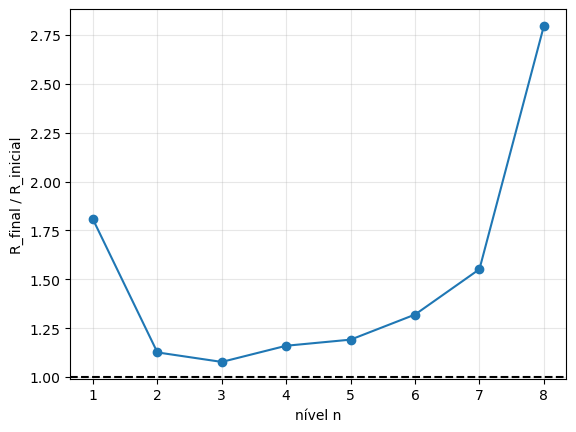

In [ ]:



def testar_convergencia_radial(
    nivel_max,
    N_particulas,
    r0,
    pasta_saida="convergencia_radial",
    nivel_min=1,
    usar_raio="max"  # "max" ou "mean"
):
    """
    Testa convergência radial em torno do ponto fixo r0.
    
    Para cada nível n:
      - simula uma nuvem inicial
      - plota apenas os pontos finais
      - desenha o círculo inicial e o círculo final
      - calcula fator de contração radial

    Retorna:
      dict com métricas de estabilidade por nível
    """

    os.makedirs(pasta_saida, exist_ok=True)

    resultados = {
        "nivel": [],
        "R_ini": [],
        "R_fin": [],
        "fator_contracao": []
    }

    for n in range(nivel_min, nivel_max + 1):

        print(f"\nTestando convergência radial para n = {n}")

        # Escalas naturais
        L = R(n) / 8
        dt = 0.08 * R(n)
        t_max = 5

        ts, rs = simular_particulas(
            N=N_particulas,
            N_fields=n,
            dimensao_quadrado=L,
            r0=r0,
            dt=dt,
            t_max=t_max
        )

        # Pontos iniciais e finais
        r_ini = rs[0,:,:]      # (N, 2)
        r_fin = rs[-1,:,:]     # (N, 2)
        r_0 = rs[:,0,:]
        
        # Distâncias ao ponto fixo
        dist_ini = np.linalg.norm(r_ini - r0, axis=1)
        dist_fin = np.linalg.norm(r_fin - r_0[-1,:], axis=1)

        R_ini = dist_ini.max()

        if usar_raio == "mean":
            R_fin = dist_fin.mean()
        else:
            R_fin = dist_fin.max()

        fator = R_fin / R_ini

        # Salva métricas
        resultados["nivel"].append(n)
        resultados["R_ini"].append(R_ini)
        resultados["R_fin"].append(R_fin)
        resultados["fator_contracao"].append(fator)

        # ===============================
        # PLOT
        # ===============================
        plt.figure(figsize=(6, 6))

        # Pontos finais
        plt.scatter(
            r_fin[:, 0],
            r_fin[:, 1],
            s=40,
            alpha=0.8,
            label="pontos finais"
        )


        plt.scatter(
            r_0[-1, 0],
            r_0[-1, 1],
            c="red",
            s=100,
            marker="x",
            label="ponto fixo r0 no final"
        )

        theta = np.linspace(0, 2*np.pi, 400)

        # Círculo inicial
        plt.plot(
            r_0[-1, 0] + R_ini * np.cos(theta),
            r_0[-1, 1] + R_ini * np.sin(theta),
            "--",
            lw=2,
            label=f"R inicial = {R_ini:.2e}"
        )

        # Círculo final
        plt.plot(
            r_0[-1, 0] + R_fin * np.cos(theta),
            r_0[-1, 1] + R_fin * np.sin(theta),
            lw=2,
            label=f"R final = {R_fin:.2e}"
        )

        plt.axis("equal")
        plt.grid(alpha=0.3)
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(
            f"Convergência radial — n = {n}\n"
            f"R_fin / R_ini = {fator:.3f}"
        )

        nome_arquivo = os.path.join(
            pasta_saida,
            f"convergencia_radial_n{n}_x{r0[0,0]:.2f}_y{r0[0,1]:.2f}.png"
        )

        plt.savefig(nome_arquivo, dpi=200)
        plt.close()

        print(f"→ fator de contração = {fator:.3f}")
        print(f"Imagem salva em: {nome_arquivo}")

    return resultados
res = testar_convergencia_radial(
    nivel_max=8,
    N_particulas=100,
    r0=r0
)

plt.plot(res["nivel"], res["fator_contracao"], "-o")
plt.axhline(1, ls="--", c="k")
plt.xlabel("nível n")
plt.ylabel("R_final / R_inicial")
plt.grid(alpha=0.3)


Vamos usar a bump function


In [12]:
def campo_2(x, y, t, n, index):
    """
    Campo vetorial induzido por um único centro
    do nível n nos pontos (x, y).
    """
    x_centro_n = x_centros(n, index, t)

    # Diferenças vetoriais (arrays)
    dx = x - x_centro_n[0]
    dy = y - x_centro_n[1]
    r2 = dx**2 + dy**2
    R2 = R(n)**2

    vx= np.zeros_like(dx)
    vy = np.zeros_like(dy)

    poten = np.zeros_like(r2)

    mask = r2 < R2

    if np.any(mask):
        poten[mask] = (
            2*np.pi
            * np.exp(1 / ((r2[mask] / R2) - 1))
            / T(n)
        )
    vx[mask] = -dy[mask] * poten[mask]
    vy[mask] = dx[mask] * poten[mask]

    return vx, vy

def campo_total_2(x, y, t, n_max=3):
    """
    Soma o campo vetorial de todos os níveis
    e todos os centros hierárquicos.
    """
    Vx = np.zeros_like(x)
    Vy = np.zeros_like(y)

    for n in range(1, n_max + 1):
        for idx in indices_nivel(n):
            vx, vy = campo_2(x, y, t, n, list(idx))
            Vx += vx
            Vy += vy

    return Vx, Vy

def simular_particulas_2(N, N_fields, dimensao_quadrado, r0, dt=0.01, t_max=1):
    """
    Simula N partículas em um pequeno quadrado
    ao redor da posição inicial r0.
    """

    def funcao(t, r):
        x = r[:, 0]
        y = r[:, 1]
        Vx, Vy = campo_total_2(x, y, t, N_fields)
        return np.column_stack((Vx, Vy))

    L = dimensao_quadrado

    # Distribuição inicial uniforme em um círculo de raio L/2
    R0 = L / 2

    theta = np.random.uniform(0, 2*np.pi, size=N-1)
    u = np.random.uniform(0, 1, size=N-1)

    r = R0 * np.sqrt(u)

    dx = r * np.cos(theta)
    dy = r * np.sin(theta)

    particle_t0 = r0 + np.column_stack((dx, dy))

    # adiciona a partícula central exatamente em r0
    particle_t0 = np.vstack((r0,particle_t0))

    t, r = solve_RK4(funcao, particle_t0, 0.0, dt, t_max)
    return t, r




Testando convergência radial para n = 1
→ fator de contração = 2.342
Imagem salva em: convergencia_radial_2/convergencia_radial_n1_x0.52_y0.35.png

Testando convergência radial para n = 2
→ fator de contração = 1.280
Imagem salva em: convergencia_radial_2/convergencia_radial_n2_x0.52_y0.35.png


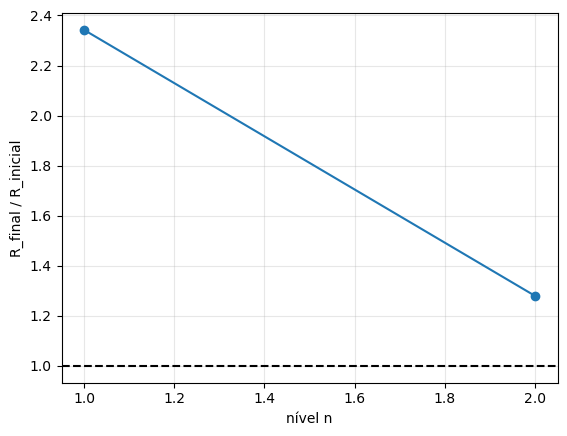

In [ ]:



def testar_convergencia_radial(
    nivel_max,
    N_particulas,
    r0,
    pasta_saida="convergencia_radial_2",
    nivel_min=1,
    usar_raio="max"  # "max" ou "mean"
):
    """
    Testa convergência radial em torno do ponto fixo r0.
    
    Para cada nível n:
      - simula uma nuvem inicial
      - plota apenas os pontos finais
      - desenha o círculo inicial e o círculo final
      - calcula fator de contração radial

    Retorna:
      dict com métricas de estabilidade por nível
    """

    os.makedirs(pasta_saida, exist_ok=True)

    resultados = {
        "nivel": [],
        "R_ini": [],
        "R_fin": [],
        "fator_contracao": []
    }

    for n in range(nivel_min, nivel_max + 1):

        print(f"\nTestando convergência radial para n = {n}")

        # Escalas naturais
        L = R(n) / 16
        dt = 0.08 * R(n)
        t_max = 5

        ts, rs = simular_particulas_2(
            N=N_particulas,
            N_fields=n,
            dimensao_quadrado=L,
            r0=r0,
            dt=dt,
            t_max=t_max
        )

        # Pontos iniciais e finais
        r_ini = rs[0,:,:]      # (N, 2)
        r_fin = rs[-1,:,:]     # (N, 2)
        r_0 = rs[:,0,:]
        
        # Distâncias ao ponto fixo
        dist_ini = np.linalg.norm(r_ini - r0, axis=1)
        dist_fin = np.linalg.norm(r_fin - r_0[-1,:], axis=1)

        R_ini = dist_ini.max()

        if usar_raio == "mean":
            R_fin = dist_fin.mean()
        else:
            R_fin = dist_fin.max()

        fator = R_fin / R_ini

        # Salva métricas
        resultados["nivel"].append(n)
        resultados["R_ini"].append(R_ini)
        resultados["R_fin"].append(R_fin)
        resultados["fator_contracao"].append(fator)

        # ===============================
        # PLOT
        # ===============================
        plt.figure(figsize=(6, 6))

        # Pontos finais
        plt.scatter(
            r_fin[:, 0],
            r_fin[:, 1],
            s=40,
            alpha=0.8,
            label="pontos finais"
        )


        plt.scatter(
            r_0[-1, 0],
            r_0[-1, 1],
            c="red",
            s=100,
            marker="x",
            label="ponto fixo r0 no final"
        )

        theta = np.linspace(0, 2*np.pi, 400)

        # Círculo inicial
        plt.plot(
            r_0[-1, 0] + R_ini * np.cos(theta),
            r_0[-1, 1] + R_ini * np.sin(theta),
            "--",
            lw=2,
            label=f"R inicial = {R_ini:.2e}"
        )

        # Círculo final
        plt.plot(
            r_0[-1, 0] + R_fin * np.cos(theta),
            r_0[-1, 1] + R_fin * np.sin(theta),
            lw=2,
            label=f"R final = {R_fin:.2e}"
        )

        plt.axis("equal")
        plt.grid(alpha=0.3)
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(
            f"Convergência radial — n = {n}\n"
            f"R_fin / R_ini = {fator:.3f}"
        )

        nome_arquivo = os.path.join(
            pasta_saida,
            f"convergencia_radial_n{n}_x{r0[0,0]:.2f}_y{r0[0,1]:.2f}.png"
        )

        plt.savefig(nome_arquivo, dpi=200)
        plt.close()

        print(f"→ fator de contração = {fator:.3f}")
        print(f"Imagem salva em: {nome_arquivo}")

    return resultados
res = testar_convergencia_radial(
    nivel_max=8,
    nivel_min=8,
    N_particulas=100,
    r0=r0
)

plt.plot(res["nivel"], res["fator_contracao"], "-o")
plt.axhline(1, ls="--", c="k")
plt.xlabel("nível n")
plt.ylabel("R_final / R_inicial")
plt.grid(alpha=0.3)


In [ ]:
def testar_estabilidade_2(
    nivel_max,
    
    N_particulas,
    r0,
    pasta_saida="estabilidade_2",
    nivel_min = 1
):
    """
    Testa a estabilidade do ponto r0 para diferentes números de níveis do campo.
    Para cada nível n:
      - simula uma nuvem de partículas ao redor de r0
      - plota as trajetórias
      - salva a figura em disco
    """

    os.makedirs(pasta_saida, exist_ok=True)

    for n in tqdm(
        range(nivel_min, nivel_max + 1),
        desc="Testando níveis",
        unit="nível"
    ):


        # Escalas naturais do nível
        L = R(n)/16         # tamanho da nuvem inicial
        dt = 0.08 * R(n)             # passo temporal
        t_max = 5         # tempo total (alguns períodos)

        print(f"Testando estabilidade para n = {n}")

        ts, rs = simular_particulas_2(
            N=N_particulas,
            N_fields=n,
            dimensao_quadrado=L,
            r0=r0,
            dt=dt,
            t_max=t_max
        )

        # rs tem shape (Nt, N, 2)
        Nt = rs.shape[0]

        plt.figure(figsize=(6, 6))


        cores = plt.cm.viridis(np.linspace(0, 1, N_particulas))

        for i in range(N_particulas):
            # Trajetória
            plt.plot(
                rs[:, i, 0],
                rs[:, i, 1],
                lw=1,
                alpha=0.4,
                color=cores[i]
            )

            # Ponto inicial (vazado)
            plt.scatter(
                rs[0, i, 0],
                rs[0, i, 1],
                facecolors="none",
                edgecolors=cores[i],
                s=30,
                linewidths=1.5
            )

            # Ponto final (bem visível)
            plt.scatter(
                rs[-1, i, 0],
                rs[-1, i, 1],
                color=cores[i],
                s=30,
                zorder=3
            )

        # Ponto central
        plt.scatter(
            r0[0, 0],
            r0[0, 1],
            c="red",
            s=100,
            marker="x",
            linewidths=2,
            label="ponto r0"
        )

        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Estabilidade em torno de r0 — Níveis até n = {n}")
        plt.legend()
        plt.grid(alpha=0.3)


        nome_arquivo = os.path.join(
            pasta_saida,
            f"estabilidade_nivel_{n}_em_x{r0[0,0]:.2f}_y{r0[0,1]:.2f}em.png"
        )
        plt.savefig(nome_arquivo, dpi=200)
        plt.close()

        print(f"Imagem salva em: {nome_arquivo}")

r0 = np.array([[np.pi/6, np.sqrt(2)/4]])

testar_estabilidade_2(
    nivel_max=6,
    N_particulas=50,
    r0=r0,
    nivel_min = 1
)

Testando níveis:   0%|          | 0/6 [00:00<?, ?nível/s]

Testando estabilidade para n = 1


Testando níveis:  17%|█▋        | 1/6 [00:00<00:01,  2.83nível/s]

Imagem salva em: estabilidade_2/estabilidade_nivel_1_em_x0.52_y0.35em.png
Testando estabilidade para n = 2


Testando níveis:  33%|███▎      | 2/6 [00:00<00:01,  2.70nível/s]

Imagem salva em: estabilidade_2/estabilidade_nivel_2_em_x0.52_y0.35em.png
Testando estabilidade para n = 3


Testando níveis:  50%|█████     | 3/6 [00:01<00:01,  1.92nível/s]

Imagem salva em: estabilidade_2/estabilidade_nivel_3_em_x0.52_y0.35em.png
Testando estabilidade para n = 4


Testando níveis:  67%|██████▋   | 4/6 [00:05<00:03,  1.78s/nível]

Imagem salva em: estabilidade_2/estabilidade_nivel_4_em_x0.52_y0.35em.png
Testando estabilidade para n = 5


Testando níveis:  83%|████████▎ | 5/6 [00:36<00:12, 12.41s/nível]

Imagem salva em: estabilidade_2/estabilidade_nivel_5_em_x0.52_y0.35em.png
Testando estabilidade para n = 6


# ======================================================================
# TESTAR LYAPUNOV
# ======================================================================

In [ ]:
def lyapunov_maximo(
    r0,
    N_fields,
    dt=0.01,
    t_max=50,
    delta0=1e-6,
    n_renorm=10
):
    """
    Calcula o expoente de Lyapunov máximo usando
    renormalização periódica.
    """

    # condição inicial e perturbação
    theta = np.random.uniform(0, 2*np.pi)
    delta_vec = delta0 * np.array([np.cos(theta), np.sin(theta)])

    r = r0.copy()
    r_pert = r0 + delta_vec

    soma_logs = 0.0
    tempo_total = 0.0

    for _ in range(int(t_max / (n_renorm * dt))):

        # empilha as duas partículas
        r_init = np.vstack([r, r_pert])

        def funcao(t, R):
            x = R[:, 0]
            y = R[:, 1]
            Vx, Vy = campo_total(x, y, t, N_fields)
            return np.column_stack((Vx, Vy))

        _, R = solve_RK4(
            funcao,
            r_init,
            0.0,
            dt,
            n_renorm * dt
        )

        r = R[-1, 0]
        r_pert = R[-1, 1]

        delta = r_pert - r
        dist = np.linalg.norm(delta)

        soma_logs += np.log(dist / delta0)
        tempo_total += n_renorm * dt

        # renormalização
        delta = delta / dist
        r_pert = r + delta0 * delta

    return soma_logs / tempo_total

for n in range(1, 9):
    lam = lyapunov_maximo(
        r0=np.array([np.pi/6, np.sqrt(2)/4]),
        N_fields=n,
        dt=0.01,
        t_max=80
    )
    print(f"Níveis = {n}, Lyapunov = {lam:.4f}")

NameError: name 'np' is not defined